In [110]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge


from sklearn.linear_model import LassoCV, Lasso
import numpy as np
from sklearn.datasets import make_regression

from csv_reader import *
from csv_setup import *


In [111]:
from sklearn.preprocessing import MinMaxScaler

# This function will normalize the count column
# This will decrease the variance, and therefore reduce the Test MSE

def get_bike_sharing_df_clean_mod():
    # Copy orig to new df
    bike_sharing_df_orig = get_bike_sharing_df_clean()
    bike_sharing_df = bike_sharing_df_orig.copy()
    
    values = bike_sharing_df.values    
    scaler = MinMaxScaler()
    values_scale = scaler.fit_transform(values)
    temp_df = pd.DataFrame(values_scale)
    
    
    bike_sharing_df['cnt'] = temp_df[7]
    
    return bike_sharing_df

In [112]:
# If you want to see the normalized results uncomment line 2 and comment line 4
# bike_sharing_df = get_bike_sharing_df_clean_mod()

bike_sharing_df = get_bike_sharing_df_clean()


print("Columns of the dataframe: \n" + str(bike_sharing_df.columns))

# printing the entire dataframe
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#print(bike_sharing_df)


Columns of the dataframe: 
Index(['hr', 'holiday', 'workingday', 'weathersit', 'atemp', 'hum',
       'windspeed', 'cnt', 'no_snow', 'medium_snow', 'heavy_snow'],
      dtype='object')


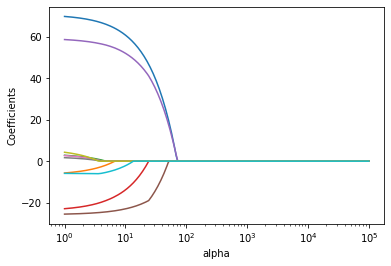

In [139]:


# Count variable that we are going to be predicting
Y = bike_sharing_df.cnt
# Features that we are going to be fitting
X = bike_sharing_df.loc[:].drop(columns=["cnt"])

# Split the data
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 1)

# print(y_train)

n_folds = 5
n_alphas = 200
alphas = np.logspace(0, 5, n_alphas) #grid search for lambda (aka 'alpha')

parameters = { 'lasso__alpha':alphas}

scaler = StandardScaler()
lasso = Lasso(normalize=False,tol=2,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)

gs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
gs.fit(X_train,y_train)

# 0-5 because of no negative logs
alphas = np.logspace(0, 5, n_alphas)

coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'lasso__alpha':alphas}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in alphas:
    pipe.set_params(lasso__alpha=a)
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure()
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');


# plt.figure()
# ax = plt.gca()
# ax.plot(alphas, coefs,'o')
# ax.set_xscale('log')
#
# plt.axis('tight')
# plt.xlabel('alpha')
# plt.ylabel('Coefficients')
# plt.title('Zoomed in')
# plt.xlim(.01,100)


In [140]:
# coefficients {𝛽1,…,𝛽𝑝} for the last fitted model in the above for loop
pipe.named_steps['lasso'].coef_

array([ 0., -0.,  0., -0.,  0., -0.,  0.,  0., -0., -0.])

In [141]:
# B0
pipe.named_steps['lasso'].intercept_

188.19144550373616

In [142]:
# Average of Y's
np.mean(y_train)

188.19144550373616

In [143]:
# Best alpha
best_alpha = gs.best_params_['lasso__alpha']
print(best_alpha)

8.50448934180268


In [144]:
scaler = StandardScaler()
scaler.fit(X_train)

lasso = Lasso(alpha=best_alpha,normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)
pipe.fit(X_train, y_train)

best_coef_lasso = pipe.named_steps['lasso'].coef_

# print('The final set of coefficients: ')
print(best_coef_lasso)

[ 45.93553967  -0.           0.          -0.          52.96956004
 -35.0163209    0.           0.          -0.          -4.88434863]


In [145]:
print('\nCoefficients  [lasso]')
for i in range(0,10):
    print('   Feature %2i:  %.2f'%(i,\
                    best_coef_lasso[i]))


Coefficients  [lasso]
   Feature  0:  45.94
   Feature  1:  -0.00
   Feature  2:  0.00
   Feature  3:  -0.00
   Feature  4:  52.97
   Feature  5:  -35.02
   Feature  6:  0.00
   Feature  7:  0.00
   Feature  8:  -0.00
   Feature  9:  -4.88


In [146]:
np.count_nonzero(best_coef_lasso)

4

In [147]:
y_pred = pipe.predict(x_test)

print(y_pred)


mse_test_using_lasso = mean_squared_error(y_test,y_pred)
# print(mse_test_using_coef_true)
print('\nTest set MSE using ridge coefficients: %.2f'%mse_test_using_lasso)


[129.21186538 157.74225532 176.45189612 ... 167.63391804 101.05736538
 314.33019191]

Test set MSE using ridge coefficients: 23108.56


In [148]:

lm = pipe

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)

print('Train Score: ')
print(r2_score(y_train, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test, y_test_pred))

Train Score: 
0.32234953672588706

Test Score: 
0.3233179650392831


5736
5736


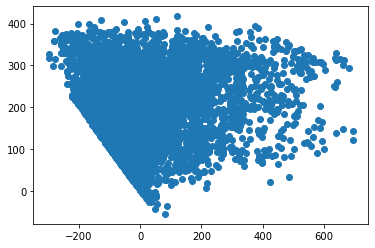

In [156]:
print(len(y_test))
print(len(y_pred))
residuals = y_test.subtract(y_pred)




plt.scatter(residuals,y_pred)

plt.show()